In [1]:
from pathlib import Path
import numpy as np
import skimage.io as skio
import matplotlib.pyplot as plt
import xmltodict
import zarr

In [2]:
im_name = "Region 9"
atlas_export = Path('E:\PROJECTS\CCI\ATLAS-exports\example-20nm')
atlas_metadata = atlas_export.joinpath(im_name + '.xml')

tif_list = [f for f in atlas_export.iterdir() if f.is_file and f.name.endswith('.tif')]

print(f'found {len(tif_list)} images in the folder')

found 1560 images in the folder


In [3]:
#exploring the meta data a bit, there is a list of dict for the tiles and a first layer of general info
with open(atlas_metadata, "rb") as f:
    stitching_dict = xmltodict.parse(f, xml_attribs=True)

stitching_dict['AtlasTiledExport'].keys()

im_width  = int(stitching_dict['AtlasTiledExport']['Width'])
im_height = int(stitching_dict['AtlasTiledExport']['Height'])
pix_size = stitching_dict['AtlasTiledExport']['PixelSize']

print(f"the stitched image array is of size: {im_width}x{im_height}")

the stitched image array is of size: 80054x79336


In [4]:
#exploring the meta data a bit, there is a list of dict for the tiles and a first layer of general info
with open(atlas_metadata, "rb") as f:
    stitching_dict = xmltodict.parse(f, xml_attribs=True)

stitching_dict['AtlasTiledExport']['Tiles'].keys()

tile_list = stitching_dict['AtlasTiledExport']['Tiles']['Tile']

ntiles = len(tile_list)
ntiles

max_r = 0
max_c = 0
for i in tile_list:
    if int(i['Row']) > max_r:
        max_r = int(i['Row'])
    if int(i['Column']) > max_c:
        max_c = int(i['Column']) 
print(f"found cols: {max_c}, and rows: {max_r}")

found cols: 39, and rows: 38


im0 has shape (2048, 2048) and type: uint8


(-0.5, 2047.5, 2047.5, -0.5)

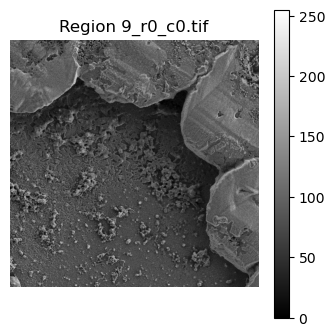

In [5]:
# opening an image as sanity check
im_dic = tile_list[0]
im_name = Path(im_dic['FileName']).name
im_path = atlas_export.joinpath(im_name)
im0 = skio.imread(im_path, plugin="tifffile")

print(f"im0 has shape {im0.shape} and type: {im0.dtype}")

plt.figure(figsize=(4, 4), dpi=100)
plt.imshow(im0, cmap="gray")
plt.colorbar()
plt.title(im_name)
plt.axis('off')

In [6]:
from tqdm.auto import tqdm
from functools import partial
from multiprocess import Pool
from dask.diagnostics import ProgressBar
ProgressBar().register()

def rm_tree(pth):
    pth = Path(pth)
    for child in pth.glob('*'):
        if child.is_file():
            child.unlink()
        else:
            rm_tree(child)
    pth.rmdir()

def optimal_size(current_size, res_levels):
    # helper function that asses the best size given the desired resolution level
    
    div_factor = np.power(2,res_levels)
    rem = np.remainder(current_size, div_factor)

    print(f'current size: {current_size}, factor: {div_factor}, reminder: {rem}')

    if rem > 0:
        extra = div_factor-rem
    else:
        extra = 0

    print(f'we need to add: {extra}, so new size is: {current_size+extra}')

    return current_size+extra

def add_tile(atile_dict, im_array, atlas_export):
    from pathlib import Path
    from skimage.io import imread
    im_name = Path(atile_dict['FileName']).name
    im_path = atlas_export.joinpath(im_name)
    im_tmp = imread(im_path, plugin="tifffile")
    x0 = int(atile_dict['StartX'])
    y0 = int(atile_dict['StartY'])
    im_array[y0:y0+im_tmp.shape[0],x0:x0+im_tmp.shape[1]] = im_tmp


In [7]:
res_levels = 4

total_h = int(optimal_size(im_height, res_levels))
total_w = int(optimal_size(im_width, res_levels))

print(f"due to future downscaling the final image will be h:{total_h}, w:{total_w}")

current size: 79336, factor: 16, reminder: 8
we need to add: 8, so new size is: 79344
current size: 80054, factor: 16, reminder: 6
we need to add: 10, so new size is: 80064
due to future downscaling the final image will be h:79344, w:80064


In [8]:
z0_str = f"./{atlas_metadata.stem}.zarr"
z0_path = Path(z0_str)

if z0_path.exists():
  rm_tree(z0_path)
  
store = zarr.DirectoryStore(z0_path)
chunk_size = np.max(im0.shape)
print(f'Chunk size: {chunk_size},{chunk_size}')
z = zarr.creation.open_array(store=store, mode='a', shape=(total_h,total_w), chunks=(chunk_size,chunk_size), dtype=im0.dtype)
z

Chunk size: 2048,2048


<zarr.core.Array (79344, 80064) uint8>

In [9]:
#def get_chunks(l, n):
#    return [l[i:i+n] for i in range(0, len(l), n)]

#chunks = get_chunks(tile_list,5)

with Pool(5) as pool:
    seq = [item for item in tile_list]
    pool.map(partial(add_tile, im_array=z, atlas_export=atlas_export), seq)


In [10]:
import dask.array as da
# like numpy.mean, but maintains dtype, helper function
def mean_dtype(arr, **kwargs):
    return np.mean(arr, **kwargs).astype(arr.dtype)

In [11]:
# it is still not quite clear to me why, but we need to rechunk de data at this stage
# if not zarr writting later on will fail
d0 = da.from_zarr(store).rechunk(chunk_size,chunk_size)
d0

dask.array<from-zarr, shape=(79344, 80064), dtype=uint8, chunksize=(2048, 2048), chunktype=numpy.ndarray>

In [12]:
d1 = da.coarsen(mean_dtype, d0, {0:2,1:2}).rechunk(int(chunk_size/2),int(chunk_size/2))

d2 = da.coarsen(mean_dtype, d0, {0:4,1:4}).rechunk(int(chunk_size/2),int(chunk_size/2))

d3 = da.coarsen(mean_dtype, d0, {0:8,1:8}).rechunk(int(chunk_size/2),int(chunk_size/2))
d3

dask.array<rechunk-merge, shape=(9918, 10008), dtype=uint8, chunksize=(1024, 1024), chunktype=numpy.ndarray>

[########################################] | 100% Completed | 6.85 ss


(-0.5, 10007.5, 9917.5, -0.5)

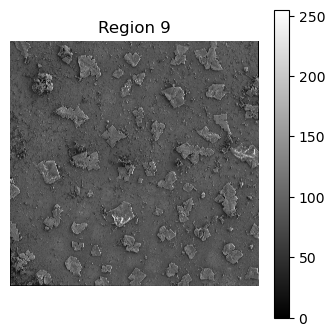

In [13]:
plt.figure(figsize=(4, 4), dpi=100)
plt.imshow(d3, cmap="gray")
plt.colorbar()
plt.title(atlas_metadata.stem)
plt.axis('off')

In [14]:
from ome_zarr.io import parse_url
from ome_zarr.writer import write_multiscale
from ome_zarr.writer import write_multiscales_metadata

In [15]:
# I can probably build this programmatically, for the moment I take a shortcut. 

initial_pix_size = float(pix_size['Value'])
initial_pix_unit = pix_size['Unit']
ch_name = "SEM"
coordtfs = [
        [{'type': 'scale', 'scale': [initial_pix_size,initial_pix_size]},
         {'type': 'translation', 'translation': [0, 0]}],
        [{'type': 'scale', 'scale': [initial_pix_size*2,initial_pix_size*2]},
         {'type': 'translation', 'translation': [0, 0]}],
        [{'type': 'scale', 'scale': [initial_pix_size*4,initial_pix_size*4]},
         {'type': 'translation', 'translation': [0, 0]}],
        [{'type': 'scale', 'scale': [initial_pix_size*8,initial_pix_size*8]},
         {'type': 'translation', 'translation': [0, 0]}],
        ]
axes = [{'name': 'y', 'type': 'space', 'unit': initial_pix_unit},
        {'name': 'x', 'type': 'space', 'unit': initial_pix_unit}]

In [16]:
# Open the zarr group manually
path_str = "./"+atlas_metadata.stem+"-ome.zarr"
path = Path(path_str)

if path.exists():
  rm_tree(path)


store = parse_url(path, mode='w').store
root = zarr.group(store=store)

# Use OME write multiscale;
write_multiscale([d0, d1, d2, d3],
        group=root, axes=axes, coordinate_transformations=coordtfs
        )
# add omero metadata: the napari ome-zarr plugin uses this to pass rendering
# options to napari.
root.attrs['omero'] = {
        'channels': [{
                'color': 'ffffff',
                'label': ch_name,
                'active': True,
                'window': {
                  'end': d0.max().compute(),
                  'max': 512,
                  'start': d0.min().compute(),
                  'min': 0,
                }
                }]
        }

[########################################] | 100% Completed | 19.23 s
[########################################] | 100% Completed | 22.30 s
[########################################] | 100% Completed | 10.78 s
[########################################] | 100% Completed | 6.87 ss
[########################################] | 100% Completed | 5.12 sms
[########################################] | 100% Completed | 5.06 sms


In [17]:
if z0_path.exists():
  rm_tree(z0_path)